# Predicting Progression of Endometrial Cancer 
## *Deepika Dilip*

## Abstract 

*Background:* Recent biomedical advances have pointed to the heterogeneity of cancer subtypes. Endometrial cancer primarily affects women, and progression is dependent on a series of factors

*Methods:* We used the 2018 Memorial Sloan Kettering cohort of uterine cancer cases (N = 187). Here, we apply three classification models (logistic regression, kNN-classification, and decision trees) to predict disease progression. We integrated DNA-sequenced data with clinically annotated tables.

*Results*: Both kNN and logistic regression indicated high accuracy rates (~94%). When examining feature importance, certain mutations appeared to drive disease progression (e.g. TP53, CCND1)

*Conclusion*: Further models should integrate clinical criteria alongside mutation data. Mutations appear to be significant predictors of disease, and assays can ultimately inform treatment options.

## Introduction
Endometrial cancer is increasing in prevalence, yet treatment remains limited (1). As with many cancer types, a wider understanding of the cancer genomics and biomedical pathways can inform treatment options and cancer research. Certain clinical factors contribute towards progressm (2), including age, co-morbidities, and pathologic risk factors. Mutation profiling is especially useful in cancer research: certain mutations are indicative of disease progression, prognosis, and dictate the best chemotherapy regimen. 

Here we ask the following question: which mutations and/or clinical factors are most associated with endometrial cancer progression?

This project integrates mutation data with known clinical factors. By taking a data-driven approach, we can quantify the impact of certain biomarkers on disease progression.

## Data Wrangling

In [85]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix,classification_report

In [2]:
clinical_dat = pd.read_table("/Users/laptop/Desktop/CUNY SPS/DATA_602_FINAL/ucec_msk_2018_clinical_data.tsv")
clinical_dat_sub = clinical_dat.drop_duplicates(['Patient ID'])

In [91]:
clinical_dat_sub.head(1)

,Study ID,Patient ID,Sample ID,Cancer Type,Cancer Type Detailed,Fraction Genome Altered,Neoplasm Histologic Grade,IHC Detail,MMR-D by IHC,MSI Status,Mutation Count,Oncotree Code,First-Line Therapy PFS,POLE ultra-mutated,Progression Status,Number of Samples Per Patient,SCNA Cluster,Sex,Somatic Status,TMB (nonsynonymous)
0,ucec_msk_2018,P-0000024,P-0000024-T01-IM3,Endometrial Cancer,Uterine Endometrioid Carcinoma,0.3878,1,NaN,N,MSS,6.0,UEC,186.4,N,1,1,B,Female,Matched,6.654932


In [4]:
molecular_dat = pd.read_csv("/Users/laptop/Desktop/CUNY SPS/DATA_602_FINAL/molecular_data.csv")
mutations = molecular_dat[["sampleId", "hugoGeneSymbol", "variantType","keyword"]]

In [5]:
genes = mutations['hugoGeneSymbol'].value_counts()[mutations['hugoGeneSymbol'].value_counts()> 10].index
genes.astype(str, copy = False)
mutations = mutations[mutations['hugoGeneSymbol'].isin(genes)]
mutations = mutations.drop_duplicates(['hugoGeneSymbol','sampleId'])

In [9]:
mutations_wide = mutations.pivot(index = 'sampleId', columns = 'hugoGeneSymbol', values = 'variantType')
mutations_wide = mutations_wide.notnull()

In [49]:
# clinical_dat_sub[['Patient ID', 'Sample ID', 'Progression Status', 'Neoplasm Histologic Grade', 'Oncotree Code']]
model_dat = clinical_dat_sub[['Sample ID', 'Progression Status']].rename({'Sample ID': 'sampleId'}, axis=1)

In [52]:
mutations_wide = mutations_wide.merge(model_dat[['sampleId', 'Progression Status']], how='inner', on='sampleId')

In [92]:
mutations_wide.head(1)

,sampleId,AKT1,ALK,AMER1,ANKRD11,APC,AR,ARID1A,ARID1B,ASXL1,...,SMARCA4,SOX17,SPEN,SPOP,STAG2,TERT,TP53,TSC2,ZFHX3,Progression Status
0,P-0000024-T01-IM3,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,1


## Exploratory Data Analysis

### Clinical Data


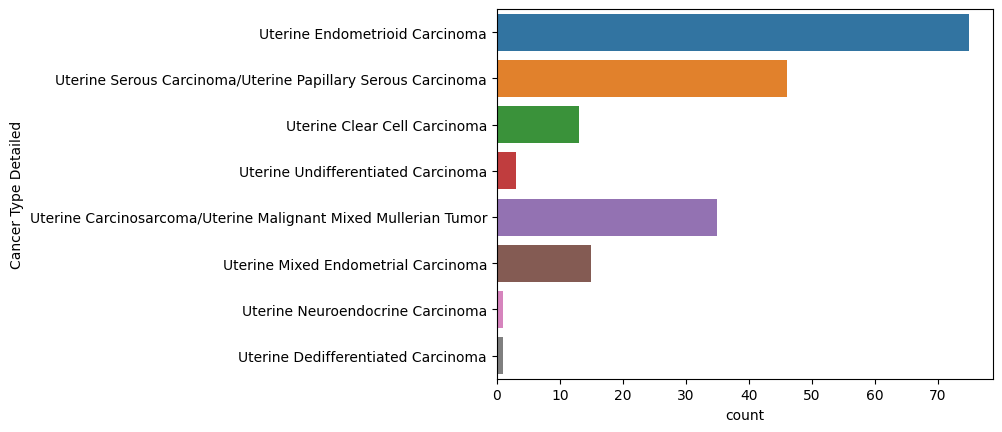

In [27]:
# clinical_dat_sub['Cancer Type Detailed'].value_counts().sort_values().plot(kind = 'barh')
type_plt = sns.countplot(y="Cancer Type Detailed", data=clinical_dat_sub)
plt.show()

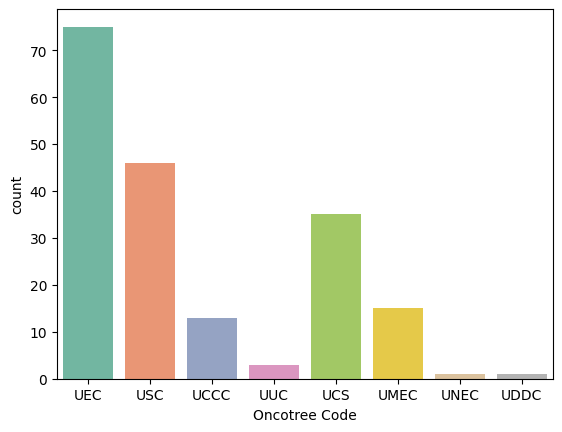

In [26]:
code = sns.countplot(x="Oncotree Code", data=clinical_dat_sub, palette = "Set2")
plt.show()

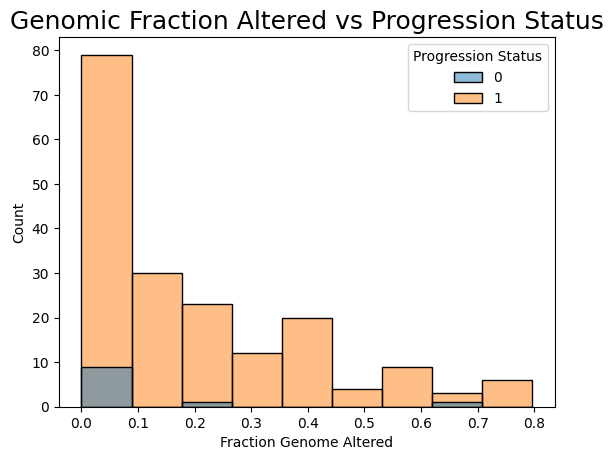

In [23]:
hist = sns.histplot(data=clinical_dat, x="Fraction Genome Altered", hue = "Progression Status")

  
# Set title for plot
hist.set_title( "Genomic Fraction Altered vs Progression Status" , size = 18 )

plt.show()

### Mutations

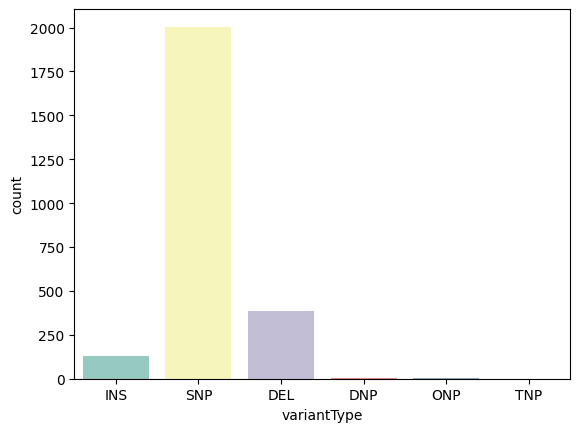

In [32]:
variant = sns.countplot(x="variantType", data=molecular_dat, palette = "Set3")
plt.show()

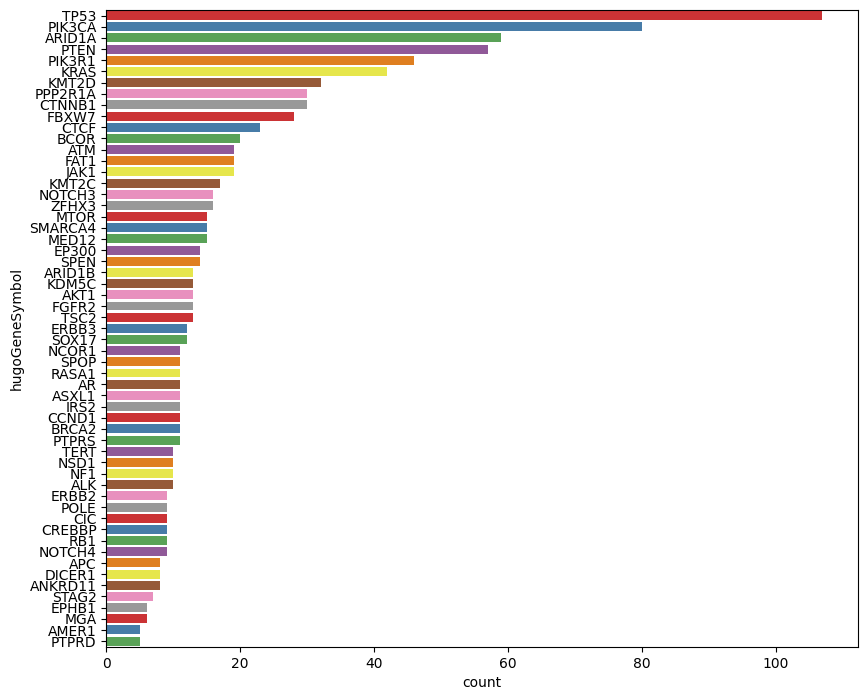

In [46]:
# mutations['hugoGeneSymbol'].value_counts().sort_values().plot(kind = 'barh')

fig, ax = plt.subplots()
fig.set_size_inches(9.7, 8.27)
sns.countplot(y="hugoGeneSymbol", data=mutations, palette = "Set1", order = mutations['hugoGeneSymbol'].value_counts().index)
plt.show()


## Data Analysis
Here, we'll fit two classification models:

1. Logistic regression
2. kNN classification
3. Decision Tree

We'll be using all the mutations as predictors, with progression as the outcome

In [75]:
X_train, X_test, y_train, y_test = train_test_split(mutations_wide.loc[:, ~mutations_wide.columns.isin(['Progression Status', 'sampleId'])], mutations_wide[['Progression Status']], random_state=42)

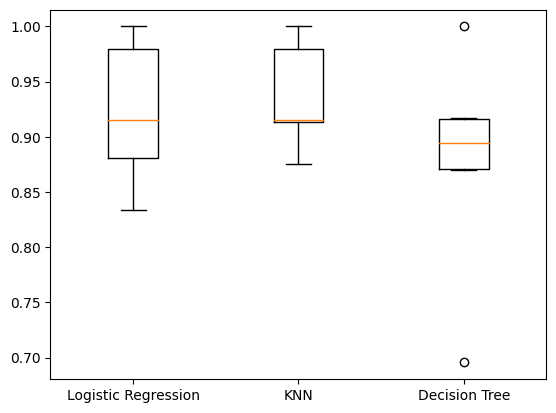

In [90]:
models = {"Logistic Regression": LogisticRegression(), "KNN": KNeighborsClassifier(), "Decision Tree": DecisionTreeClassifier()}
results = []
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train.values, y_train.values.ravel(), cv=kf) 
    results.append(cv_results)
plt.boxplot(results, labels=models.keys()) 
plt.show()

In [98]:
accuracy = {}
for name, model in models.items(): 
    model.fit(X_train, y_train)
    test_score = model.score(X_test.values, y_test.values.ravel())
    accuracy[model] = test_score

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fi

In [99]:
accuracy

{LogisticRegression(): 0.9574468085106383,
 KNeighborsClassifier(): 0.9574468085106383,
 DecisionTreeClassifier(): 0.9148936170212766}

In [122]:
logit = LogisticRegression()
logit.fit(X_train, y_train)
# get importance
df_importance = pd.DataFrame(np.transpose(logit.coef_), columns = ['Importance'])
df_mutations = pd.DataFrame(X_train.columns, columns = ['Mutation'])
df_importance = pd.concat([df_importance, df_mutations], axis=1, ignore_index=False)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

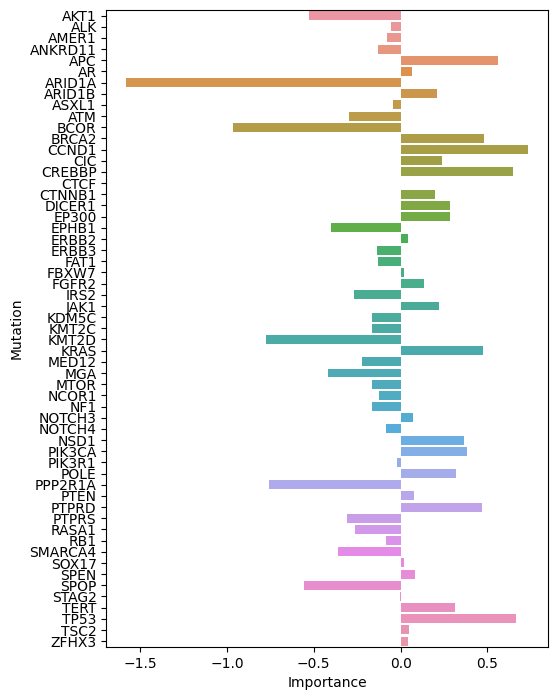

In [149]:

fig, ax = plt.subplots()
fig.set_size_inches(5.7, 8.27)
sns.barplot(data=df_importance, y="Mutation", x="Importance")
plt.show()


## References
1. Soumerai, T. E., Donoghue, M. T. A., Bandlamudi, C., Srinivasan, P., Chang, M. T., Zamarin, D., Cadoo, K. A., Grisham, R. N., O'Cearbhaill, R. E., Tew, W. P., Konner, J. A., Hensley, M. L., Makker, V., Sabbatini, P., Spriggs, D. R., Troso-Sandoval, T. A., Charen, A. S., Friedman, C., Gorsky, M., Schweber, S. J., … Hyman, D. M. (2018). Clinical Utility of Prospective Molecular Characterization in Advanced Endometrial Cancer. Clinical cancer research : an official journal of the American Association for Cancer Research, 24(23), 5939–5947. https://doi.org/10.1158/1078-0432.CCR-18-0412

2. Kong, T. W., Chang, S. J., Paek, J., Lee, Y., Chun, M., & Ryu, H. S. (2015). Risk group criteria for tailoring adjuvant treatment in patients with endometrial cancer: a validation study of the Gynecologic Oncology Group criteria. Journal of gynecologic oncology, 26(1), 32–39. https://doi.org/10.3802/jgo.2015.26.1.32